In [ ]:
import os
import sys
import urllib.request
import datetime
import time
import json
import pandas as pd

client_id = '자신의 ID'
client_secret = '자신의 secretkey'


#[CODE 1]
def getRequestUrl(url):    
    req = urllib.request.Request(url)
    req.add_header("X-Naver-Client-Id", client_id)
    req.add_header("X-Naver-Client-Secret", client_secret)
    
    try: 
        response = urllib.request.urlopen(req)
        if response.getcode() == 200:
            print ("[%s] Url Request Success" % datetime.datetime.now())
            return response.read().decode('utf-8')
    except Exception as e:
        print(e)
        print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
        return None

#[CODE 2]
def getNaverSearch(node, srcText, start, display):    
    base = "https://openapi.naver.com/v1/search"
    node = "/%s.json" % node
    parameters = "?query=%s&start=%s&display=%s" % (urllib.parse.quote(srcText), start, display)
    
    url = base + node + parameters    
    responseDecode = getRequestUrl(url)   #[CODE 1]
    
    if (responseDecode == None):
        return None
    else:
        return json.loads(responseDecode)

#[CODE 3]
def getPostData(post, jsonResult, result, cnt):    
    title = post['title']
    description = post['description']
    org_link = post['originallink']
    link = post['link']
    
    pDate = datetime.datetime.strptime(post['pubDate'],  '%a, %d %b %Y %H:%M:%S +0900')
    pDate = pDate.strftime('%Y-%m-%d %H:%M:%S')
    
    jsonResult.append({'cnt':cnt, 'title':title, 'description': description, 
'org_link':org_link,   'link': org_link,   'pDate':pDate})
    result.append([title, description])
    return    

#[CODE 0]
def main():
    node = 'news'   # 크롤링 할 대상
    srcText = input('검색어를 입력하세요: ')
    cnt = 0
    jsonResult = []
    result = []

    jsonResponse = getNaverSearch(node, srcText, 1, 100)  #[CODE 2]
    total = jsonResponse['total']
 
    while ((jsonResponse != None) and (jsonResponse['display'] != 0)):         
        for post in jsonResponse['items']:
            cnt += 1
            getPostData(post, jsonResult, result, cnt)  #[CODE 3]       
        
        start = jsonResponse['start'] + jsonResponse['display']
        jsonResponse = getNaverSearch(node, srcText, start, 100)  #[CODE 2]
       
    print('전체 검색 : %d 건' %total)
    
    with open('%s_naver_%s.json' % (srcText, node), 'w', encoding='utf8') as outfile:
        jsonFile = json.dumps(jsonResult,  indent=4, sort_keys=True,  ensure_ascii=False)
                        
        outfile.write(jsonFile)

        #파일저장 2 : csv 파일   
        columns = ["제목", "설명"]
        result_df = pd.DataFrame(result, columns = columns)
        result_df.to_csv('./%d_%s.csv', index=False, encoding='utf8')
        
    print("가져온 데이터 : %d 건" %(cnt))
    print ('%s_naver_%s.json SAVED' % (srcText, node))
    
if __name__ == '__main__':
    main()


In [2]:
# 패키지 import 
import pandas as pd # 데이터프레임형태로 구성
import glob # 파일명을 리스트 형식으로 변경
import re # 문자열에 맞는 패턴을 교체
from functools import reduce # 1차원 리스트로 변경
from nltk.tokenize import word_tokenize # 단어 토큰화 작업을 위한 모듈
from nltk.corpus import stopwords # 불용어 정보를 제공하는 모듈
from nltk.stem import WordNetLemmatizer # 단어 형태의 일반화를 위해 표제어 추출을 제공하는 모듈
from collections import Counter # 데이터 집합에서 개수를 자동으로 계산하기 위한 모듈
import matplotlib.pyplot as plt # 그래프
from wordcloud import STOPWORDS, WordCloud # 워드클라우드
import nltk 
from konlpy.tag import Okt # 명사로 변환하는 패키지 추가
from matplotlib import font_manager, rc # 폰트관련 패키지 추가
import matplotlib

In [3]:
# csv파일 읽어오기
digital_platform = pd.read_csv('C:/Users/da_mi/OneDrive/바탕 화면/4학년1학기/빅데이터/source/My_Python/201835655-박다민.csv')

In [4]:
all_title = digital_platform['제목']
all_title

0      소프트캠프, 메세지큐엔에이와 장애인 재택근무 <b>플랫폼</b> 사업화 업무협약
1                       올라케어, 카카오톡 채널 비대면 진료 서비스 시작
2                             2030 MZ세대 마케팅 나선 우리금융
3                 [알아둡시다] 행안부, 지방세 '챗봇'으로 24시간 상담한다
4                         한국조지메이슨대학교, 네이버 OGQ와 '맞손'
                           ...                     
995                  제이브이엠, 스마트공장 구축 속도···중기부 사업 선정
996           LG에너지솔루션, 'AI 드림팀' 꾸렸다…서울대‧카이스트 교수 위촉
997               보건산업진흥원, 예방의학 분야 오픈 이노베이션 참가기업 모집
998            5년 만에 열리는 제12차 WTO 각료회의…식량안보·개혁방안 모색
999               컨설턴트 출신 대기업 CEO 이렇게 많았나…실제 사업 성과는
Name: 제목, Length: 1000, dtype: object

In [5]:
#불용어 리스트 설정
stopWords = ['의한', '과', '와', '관한', '에서의', '을', '위한', '와', '의', '통한', '따른', '이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같','과', '간의', '를', '의' '우리', '때', '년', '가', '한', '지', '오', '말', '일', '그렇', '위하', '및', '에', '뒤진', '대한']
lemma = WordNetLemmatizer()

In [7]:
# 1차로 한번 정제해준다.
words = []

for title in all_title:
    EnWords = re.sub(r"[^가-힣]+", " ", str(title))
    EnWordsToken = word_tokenize(EnWords.lower()) 
    EnWordsTokenStop = [w for w in EnWordsToken if w not in stopWords] 
    EnWordsTokenStopLemma = [lemma.lemmatize(w) for w in EnWordsTokenStop] 
    words.append(EnWordsTokenStopLemma)


In [8]:
words2 = list(reduce(lambda x, y: x+y, words)) # 1차원 리스트로 변환
print(words2)

['소프트캠프', '메세지큐엔에이와', '장애인', '재택근무', '플랫폼', '사업화', '업무협약', '올라케어', '카카오톡', '채널', '비대면', '진료', '서비스', '시작', '세대', '마케팅', '나선', '우리금융', '알아둡시다', '행안부', '지방세', '챗봇', '으로', '시간', '상담한다', '한국조지메이슨대학교', '네이버', '맞손', '에너지솔루션', '인공지능', '분야', '최고', '전문가', '자문단', '꾸린다', '농업도', '플랫폼', '대세', '그린랩스', '팜모닝', '출시', '만에', '만', '회원', '돌파', '이벤터스', '웨비나', '서비스', '출시', '주년', '누적', '참가자', '만', '명', '텔레콤', '프라임', '가입하면', '미술품', '분할소유권', '증정', '광주전남본부', '디지털', '국토정보', '미래가치', '창출', '공간정보', '워크숍', '메쉬코리아', '사리원과', '디지털', '유통물류', '구축', '체결', '바이오', '열기로', '꽉', '찬', '바이오', '국제무대서', '주도권', '잡는다', '인천시', '연말까지', '지역특화', '전시', '컨벤션', '연달아', '개최', '경북도', '딥러닝', '기반', '전통기록물', '해독', '사업', '선정', '프라임', '가입자에', '미술품', '분할소유권', '제공', '이동약자', '디지털', '대전환', '제주서', '구현된다', '티몬', '만', '뷰티', '유튜버', '라뮤끄', '신규', '브랜드', '추진', '프라임', '고객', '대상', '미술품', '분할소유권', '제공', '이벤트', '진행', '패스프라임', '가입', '시', '미술품', '분할소유권', '지급', '올라케어', '카카오톡', '채널서', '비대면', '진료', '서비스', '시작', '그린랩스', '팜모닝', '만', '회원', '돌파했다', '이론보다', '기술', '융합', '교육

In [9]:
# 1차로 불용어를 제외한 리스트에서 명사만 추출
nlp = Okt()
words_N = nlp.nouns(str(words2)) # 리스트에서는 명사 추출이 불가능하기 떄문에 str로 바꿔줌
words_N

['소프트캠프',
 '메세지',
 '큐',
 '에이',
 '장애인',
 '재택근무',
 '플랫폼',
 '사업',
 '업무',
 '협약',
 '케어',
 '카카오',
 '톡',
 '채널',
 '비대',
 '진료',
 '서비스',
 '시작',
 '세대',
 '마케팅',
 '나선',
 '우리금융',
 '알',
 '행안부',
 '지방세',
 '챗봇',
 '시간',
 '상담',
 '국조',
 '메이슨',
 '대학교',
 '네이버',
 '손',
 '에너지',
 '솔루션',
 '인공',
 '지능',
 '분야',
 '최고',
 '전문가',
 '자문',
 '단',
 '농업',
 '플랫폼',
 '대세',
 '그린',
 '랩스',
 '모닝',
 '출시',
 '만',
 '회원',
 '돌파',
 '이벤',
 '터스',
 '웨비',
 '서비스',
 '출시',
 '주년',
 '누적',
 '참가자',
 '만',
 '명',
 '텔레콤',
 '프라임',
 '가입',
 '미술품',
 '분할',
 '소유권',
 '증정',
 '광주',
 '전남',
 '본부',
 '디지털',
 '국토',
 '정보',
 '미래',
 '가치',
 '창',
 '공간',
 '정보',
 '워크숍',
 '메쉬',
 '코리아',
 '사리원',
 '디지털',
 '유통',
 '물류',
 '구축',
 '체결',
 '바이오',
 '열기',
 '꽉',
 '찬',
 '바이오',
 '국제',
 '무대',
 '주도',
 '인천',
 '시',
 '연말',
 '지역',
 '특',
 '전시',
 '컨벤션',
 '연달',
 '개최',
 '경북',
 '딥',
 '러닝',
 '기반',
 '전통',
 '기록물',
 '해독',
 '사업',
 '선정',
 '프라임',
 '가입자',
 '미술품',
 '분할',
 '소유권',
 '제공',
 '이동',
 '약자',
 '디지털',
 '전환',
 '제주',
 '구현',
 '티몬',
 '만',
 '뷰티',
 '유튜버',
 '뮤',
 '신규',
 '브랜드',
 '추진',
 '프라임',
 '고객',
 '대상',
 '미술품

In [10]:
count = Counter(words_N)
count #출력하여 내용 확인

Counter({'소프트캠프': 3,
         '메세지': 2,
         '큐': 2,
         '에이': 3,
         '장애인': 5,
         '재택근무': 3,
         '플랫폼': 131,
         '사업': 47,
         '업무': 16,
         '협약': 22,
         '케어': 6,
         '카카오': 12,
         '톡': 7,
         '채널': 6,
         '비대': 9,
         '진료': 7,
         '서비스': 49,
         '시작': 14,
         '세대': 11,
         '마케팅': 8,
         '나선': 3,
         '우리금융': 58,
         '알': 4,
         '행안부': 5,
         '지방세': 12,
         '챗봇': 6,
         '시간': 10,
         '상담': 11,
         '국조': 1,
         '메이슨': 1,
         '대학교': 2,
         '네이버': 10,
         '손': 8,
         '에너지': 8,
         '솔루션': 24,
         '인공': 8,
         '지능': 18,
         '분야': 16,
         '최고': 7,
         '전문가': 11,
         '자문': 15,
         '단': 16,
         '농업': 1,
         '대세': 5,
         '그린': 7,
         '랩스': 5,
         '모닝': 5,
         '출시': 21,
         '만': 25,
         '회원': 6,
         '돌파': 6,
         '이벤': 1,
         '터스': 1,
         

In [11]:
# 단어수를 count
word_count = dict()

for tag, counts in count.most_common(50):
    if(len(str(tag))>1):
        word_count[tag] = counts
        print("%s : %d" % (tag, counts))

디지털 : 137
플랫폼 : 131
스타트업 : 97
코리아 : 65
온라인 : 61
예약 : 61
우리금융 : 58
지원 : 56
선발 : 55
메타 : 54
버스 : 53
모델 : 53
디노 : 52
서비스 : 49
리나 : 48
사업 : 47
넷마블 : 47
기업 : 44
지역 : 43
화보 : 42
휴먼 : 40
개최 : 38
론칭 : 38
발탁 : 36
모집 : 33
패션 : 33
바이오 : 32
인재 : 31
하이닉스 : 31
육성 : 31
선정 : 30
투자 : 30
나일론 : 30
샌드박스 : 30
이승희 : 30
프로그램 : 30
반도체 : 29
잡지 : 29
한국 : 28
개발 : 28
신세계 : 28
하이 : 28
빌라 : 27
기반 : 26
기술 : 26


In [12]:
#주제어를 제외하고 싶을때는 word_count['디지털']과 word_count['플랫폼']추가
# 원하는 폰트 불러오기
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
matplotlib.rc('font', family = font_name)

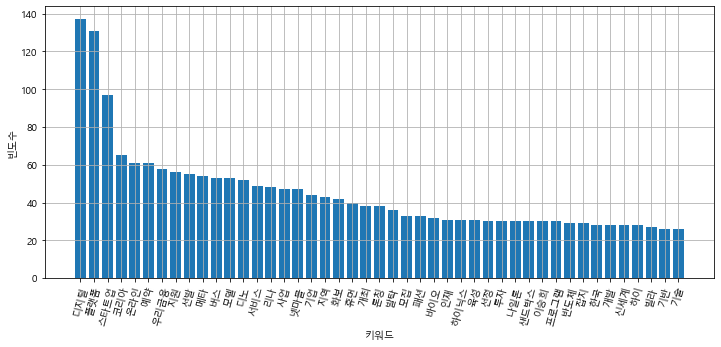

In [13]:
plt.figure(figsize = (12, 5))
plt.xlabel('키워드')
plt.ylabel('빈도수')
plt.grid(True)
sorted_Keys = sorted(word_count, key = word_count.get, reverse = True)
sorted_Values = sorted(word_count.values(), reverse = True)
plt.bar(range(len(word_count)), sorted_Values, align = 'center')
plt.xticks(range(len(word_count)), list(sorted_Keys), rotation = '75')
plt.show()

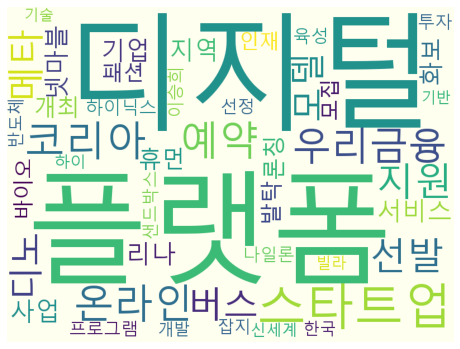

In [14]:
wc = WordCloud(font_path, background_color = 'ivory', width = 800, height = 600)
cloud = wc.generate_from_frequencies(word_count) # 미리 정의된 단어의 빈도수 를 이용하여 워드 클라우드를 그림
plt.figure(figsize = (8, 8)) # 사이즈 설정
plt.imshow(cloud) # 생성된 워드클라우드를 쥬피터 노트북 상에 표
plt.axis('off')
plt.show()

In [15]:
# 현재 jupyter notebook 코드를 저장한 곳에 database_cloud.jpg로 저장
cloud.to_file('title' + '_cloud.jpg')

In [16]:
all_description = digital_platform['설명']
all_description

0      재택근무 <b>플랫폼</b> 공동 사업화'를 위한 업무협약을 체결했다고 14일 밝혔...
1        비대면 진료 &amp; 약 배송 <b>플랫폼</b> 올라케어가 앱 설치 없이 카...
2      이번 후원을 통해 <b>디지털</b> 종합금융그룹과 MZ세대를 대표하는 금융그룹으로...
3      자동차세․재산세 등 지방세 24시간 상담… 납세 편의 대폭 향상 시범사업 거쳐 10...
4      네이버 OGQ는 네이버, 아프리카TV와 합작해 스티커, 이미지, 동영상, 폰트, 음...
                             ...                        
995    Biz <b>플랫폼</b>을 마련할 계획이다. 또 ▲조제설비 이상여부 사전감지 예지...
996    빅데이터 <b>플랫폼</b> 수립 전략 등을 이끌 계획이다. 윤 교수는 &quot;...
997    모집분야는 △<b>디지털</b> 기반 시뮬레이션 및 가상환자(의료영상 x 바이오마커...
998    동시에 <b>디지털</b>·기후변화 등 신(新)통상 이슈에 대해 회원국들이 결집된 ...
999    조영서 KB금융지주 <b>디지털플랫폼</b>총괄 전무, 장호준 SC제일은행 부행장,...
Name: 설명, Length: 1000, dtype: object

In [17]:
#불용어 리스트 설정
stopWords = ['의한', '과', '와', '관한', '에서의', '을', '위한', '와', '의', '통한', '따른', '이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같','과', '간의', '를', '의' '우리', '때', '년', '가', '한', '지', '오', '말', '일', '그렇', '위하', '및', '에', '뒤진', '대한']
lemma = WordNetLemmatizer()

In [18]:
# 1차로 한번 정제해준다.
descrip = []

for title in all_description:
    EnWords = re.sub(r"[^가-힣]+", " ", str(title))
    EnWordsToken = word_tokenize(EnWords.lower()) 
    EnWordsTokenStop = [w for w in EnWordsToken if w not in stopWords] 
    EnWordsTokenStopLemma = [lemma.lemmatize(w) for w in EnWordsTokenStop] 
    descrip.append(EnWordsTokenStopLemma)


In [19]:
descrip2 = list(reduce(lambda x, y: x+y, descrip)) # 1차원 리스트로 변환
print(descrip2)

['재택근무', '플랫폼', '공동', '사업화', '업무협약을', '체결했다고', '밝혔다', '메세지큐엔에이는', '장애인', '별도의', '가상사설망', '설치', '없이도', '사무실과', '동일한', '디지털', '작업', '환경에서', '업무를', '수행할', '있고', '리모트', '비대면', '진료', '약', '배송', '플랫폼', '올라케어가', '앱', '설치', '없이', '카카오톡', '채널을', '통해', '비대면', '진료부터', '약', '디지털', '사회에서', '모바일', '하나로', '간편하게', '의료', '서비스를', '제공함으로써', '병원', '가기도', '힘든', '바쁜', '현대인들이', '적절한', '이번', '후원을', '통해', '디지털', '종합금융그룹과', '세대를', '대표하는', '금융그룹으로의', '자리매김을', '노린다는', '게', '회사', '측', '설명이다', '이밖에도', '우리금융은', '특화', '플랫폼', '구축도', '추진', '중이다', '세대가', '주식', '부동산', '암호화폐', '자동차세', '재산세', '지방세', '시간', '상담', '납세', '편의', '대폭', '향상', '시범사업', '거쳐', '월', '본격', '서비스', '디지털', '지방세', '상담', '플랫폼', '역할', '수행', '행정안전부가', '지방세', '납부시기', '납부방법', '감면정보', '등을', '미리', '안내하고', '네이버', '는', '네이버', '아프리카', '합작해', '스티커', '이미지', '동영상', '폰트', '음원', '다양한', '디지털', '콘텐트를', '글로벌', '소셜', '크리에이터', '플랫폼', '기업', '네이버', '와의', '협약을', '통해', '조지메이슨대학교의', '다양한', '기념품을', '서울대', '분야', '세계적', '전문가', '인으로', '구성', '디지털', '전환', '비전', '제시', '기술협력', '논의', '앞으로',

In [20]:
# 1차로 불용어를 제외한 리스트에서 명사만 추출
nlp = Okt()
descrip_N = nlp.nouns(str(descrip2)) # 리스트에서는 명사 추출이 불가능하기 떄문에 str로 바꿔줌
descrip_N

['재택근무',
 '플랫폼',
 '공동',
 '사업',
 '업무',
 '협약',
 '체결',
 '메세지',
 '큐',
 '에이',
 '장애인',
 '별도',
 '가상',
 '사설망',
 '설치',
 '사무실',
 '디지털',
 '작업',
 '환경',
 '업무',
 '수행',
 '리',
 '모트',
 '비대',
 '진료',
 '약',
 '배송',
 '플랫폼',
 '케어',
 '앱',
 '설치',
 '카카오',
 '톡',
 '채널',
 '통해',
 '비대',
 '진료',
 '약',
 '디지털',
 '사회',
 '모바일',
 '하나로',
 '의료',
 '서비스',
 '공함',
 '병원',
 '가기',
 '현대인',
 '이번',
 '후원',
 '통해',
 '디지털',
 '종합',
 '금융',
 '그룹',
 '세대',
 '대표',
 '금융',
 '그룹',
 '김',
 '게',
 '회사',
 '설명',
 '이',
 '우리금융',
 '특화',
 '플랫폼',
 '구축',
 '추진',
 '중이',
 '세대',
 '주식',
 '부동산',
 '암호',
 '화폐',
 '자동차세',
 '재산세',
 '지방세',
 '시간',
 '상담',
 '납세',
 '편의',
 '대폭',
 '향상',
 '시범',
 '사업',
 '월',
 '본격',
 '서비스',
 '디지털',
 '지방세',
 '상담',
 '플랫폼',
 '역할',
 '수행',
 '행정안전부',
 '지방세',
 '납부',
 '시기',
 '납부',
 '방법',
 '정보',
 '등',
 '미리',
 '안내',
 '네이버',
 '네이버',
 '아프리카',
 '합작',
 '스티커',
 '이미지',
 '동영상',
 '폰트',
 '음원',
 '디지털',
 '콘텐트',
 '글로벌',
 '소셜',
 '크리에이터',
 '플랫폼',
 '기업',
 '네이버',
 '협약',
 '통해',
 '조지',
 '메이슨',
 '대학교',
 '기념품',
 '서울대',
 '분야',
 '세계',
 '전문가',
 '인',
 '구성',
 '디지털',
 '전환',
 '제시',


In [21]:
count2 = Counter(descrip_N)
count2 #출력하여 내용 확인

Counter({'재택근무': 3,
         '플랫폼': 1043,
         '공동': 20,
         '사업': 232,
         '업무': 24,
         '협약': 19,
         '체결': 10,
         '메세지': 3,
         '큐': 4,
         '에이': 4,
         '장애인': 9,
         '별도': 5,
         '가상': 84,
         '사설망': 3,
         '설치': 8,
         '사무실': 4,
         '디지털': 1102,
         '작업': 10,
         '환경': 43,
         '수행': 17,
         '리': 8,
         '모트': 3,
         '비대': 32,
         '진료': 17,
         '약': 9,
         '배송': 8,
         '케어': 7,
         '앱': 78,
         '카카오': 49,
         '톡': 9,
         '채널': 9,
         '통해': 188,
         '사회': 19,
         '모바일': 54,
         '하나로': 9,
         '의료': 40,
         '서비스': 249,
         '공함': 15,
         '병원': 11,
         '가기': 7,
         '현대인': 5,
         '이번': 87,
         '후원': 1,
         '종합': 10,
         '금융': 73,
         '그룹': 59,
         '세대': 9,
         '대표': 103,
         '김': 5,
         '게': 4,
         '회사': 17,
         '설명': 12,
         '이': 35,
   

In [33]:
# 단어수를 count
word_count2 = dict()

for tag2, counts2 in count2.most_common(50):
    if(len(str(tag2))>1):
        word_count2[tag2] = counts2
        print("%s : %d" % (tag2, counts2))

디지털 : 1102
플랫폼 : 1043
메타 : 252
서비스 : 249
기반 : 246
버스 : 234
사업 : 232
테크 : 193
통해 : 188
개발 : 173
기술 : 172
기업 : 153
콘텐츠 : 151
데이터 : 140
혁신 : 128
구축 : 122
고객 : 120
활용 : 120
솔루션 : 117
지원 : 116
지능 : 116
제공 : 115
물류 : 112
모델 : 111
한국 : 111
온라인 : 110
위해 : 105
교육 : 104
대표 : 103
협력 : 101
분야 : 100
스타트업 : 100
자산 : 99
글로벌 : 94
인공 : 91
블록 : 88
이번 : 87
전환 : 87
체인 : 87
계획 : 86
자회사 : 85
가상 : 84
라며 : 80
빅데이터 : 79
대응 : 79
엔터테인먼트 : 77


In [34]:
# 주제어를 제외하고 싶을때는 word_count['디지털']과 word_count['플랫폼']추가
# 원하는 폰트 불러오기
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
matplotlib.rc('font', family = font_name)

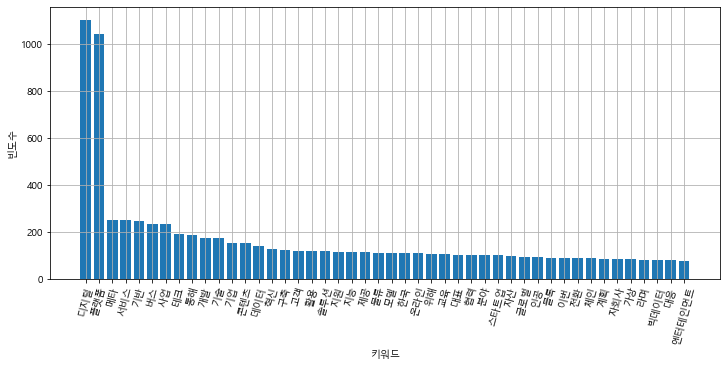

In [35]:
plt.figure(figsize = (12, 5))
plt.xlabel('키워드')
plt.ylabel('빈도수')
plt.grid(True)
sorted_Keys = sorted(word_count2, key = word_count2.get, reverse = True)
sorted_Values = sorted(word_count2.values(), reverse = True)
plt.bar(range(len(word_count2)), sorted_Values, align = 'center')
plt.xticks(range(len(word_count2)), list(sorted_Keys), rotation = '75')
plt.show()

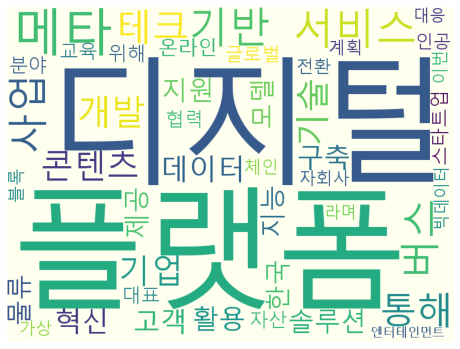

In [36]:
wc2 = WordCloud(font_path, background_color = 'ivory', width = 800, height = 600)
cloud2 = wc2.generate_from_frequencies(word_count2) # 미리 정의된 단어의 빈도수 를 이용하여 워드 클라우드를 그림
plt.figure(figsize = (8, 8)) # 사이즈 설정
plt.imshow(cloud2) # 생성된 워드클라우드를 쥬피터 노트북 상에 표현
plt.axis('off')
plt.show()

In [37]:
# 현재 jupyter notebook 코드를 저장한 곳에 database_cloud.jpg로 저장
cloud.to_file('descript' + '_cloud.jpg')